In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy.linalg as la
import scipy.stats as stats
import math
import seaborn as sns
import scipy.io
import pandas as pd
from scipy.stats.stats import pearsonr 
from runCPCA import runCPCA
from runCPCA import findLoadingsScores
from G_CPCA_Analysis import G_CPCA_Analysis
from getPcaPredCorr import getPcaPredCorr
from getPcaPredCorr import getPcaPredCorr2
from splitHalfCrossValidCpca import splitHalfCrossValidCpca
from splitHalfCrossValidCpca import runCpcaStep1
from SelectCompLoadingsBig import SelectCompLoadingsBig

In [28]:
f='MATRICS_PANSS_COMPS_Castle_Heinrich_Rossell_no_missing.csv'
Z_col=[np.arange(42,46),np.arange(48,57)]
G_col=[np.arange(6,36)]

file = pd.read_csv(f)
name=list(file)
ZGlist=list()
Z_label=list()
G_label=list()
file = file.replace([-88, -77, -99], np.nan)
for i in range(len(Z_col)):
    list.append(ZGlist,file[file.columns[Z_col[i]]])
    for j in range(len(Z_col[i])):
        list.append(Z_label,name[(Z_col[i])[j]])
for i in range(len(G_col)):
    list.append(ZGlist,file[file.columns[G_col[i]]])
    for j in range(len(G_col[i])):
        list.append(G_label,name[(G_col[i])[j]])
dataZG = pd.concat(ZGlist, axis = 1)
ZG = dataZG.dropna()
Z = ZG[ZG.columns[0:len(Z_label)]]
G = ZG[ZG.columns[len(Z_label):len(Z_label)+len(G_label)]]
Z = Z.to_numpy()
G = G.to_numpy()
Z = Z.astype(np.float64)
G = G.astype(np.float64)
params={}
params['nIter']=100
params['varimaxFlag']=True
params['G_orig']=G
params['n_bootstrap']=100
params['p_val']=0.005

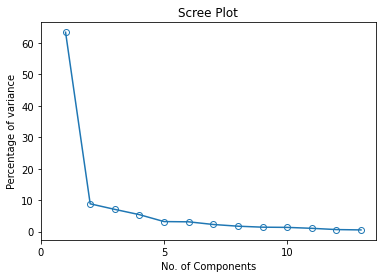

Enter the number of components: 4


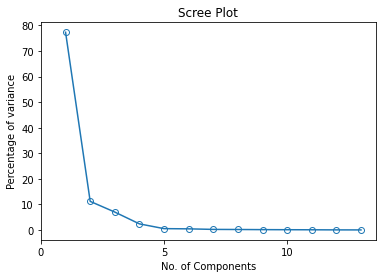

Enter the number of components: 3


Please wait…
10.0 % Completed!
20.0 % Completed!
30.0 % Completed!
40.0 % Completed!
50.0 % Completed!
60.0 % Completed!
70.0 % Completed!
80.0 % Completed!
90.0 % Completed!
100.0 % Completed!


In [29]:
G_CPCA_CV = splitHalfCrossValidCpca(Z, G, params)
BH_PCA_train = getPcaPredCorr(G_CPCA_CV['G_CPCA_train'], params)
BH_PCA_train['G_CPCA_CV'] = G_CPCA_CV
BH_PCA_test = getPcaPredCorr(G_CPCA_CV['G_CPCA_test'], params)
BH_PCA_test['G_CPCA_CV'] = G_CPCA_CV
## perform permutation tests
train_PCorr_shape=np.shape(BH_PCA_train['PCorr'])
permutePCorrTrain = np.zeros((train_PCorr_shape[0],train_PCorr_shape[1],train_PCorr_shape[2],params['n_bootstrap']))
permutePCorrTrain[:,:,:,:]=np.nan
test_PCorr_shape=np.shape(BH_PCA_test['PCorr'])
permutePCorrTest = np.zeros((test_PCorr_shape[0],test_PCorr_shape[1],test_PCorr_shape[2],params['n_bootstrap']))
permutePCorrTest[:,:,:,:]=np.nan
print('Please wait…')                          
for ii in range(0,params['n_bootstrap']):
    G_temp = np.random.permutation(G) 
    Z_temp = Z
    G_CPCA_CV_temp = splitHalfCrossValidCpca(Z_temp, G_temp, params)
    BH_PCA_temp = getPcaPredCorr2(G_CPCA_CV_temp['G_CPCA_train'], params, BH_PCA_train['nComp'])
    permutePCorrTrain[:,:,:,ii] = BH_PCA_temp['PCorr']
    BH_PCA_temp = getPcaPredCorr2(G_CPCA_CV_temp['G_CPCA_test'], params, BH_PCA_test['nComp'])
    permutePCorrTest[:,:,:,ii] = BH_PCA_temp['PCorr']
    if (ii+1)%10==0:
        print((1+ii)/params['n_bootstrap']*100,'% Completed!')
                            
#save('permutePCorr.mat','permutePCorrTest','permutePCorrTrain')
Test_s=np.shape(permutePCorrTest)
Train_s=np.shape(permutePCorrTrain)
permutePCorr_mat=np.zeros((Train_s[0],Train_s[1]+Test_s[1],Train_s[2],Train_s[3]))
for i in range(Train_s[3]):
    for j in range(Train_s[2]):
        for m in range(Train_s[1]+Test_s[1]):
            for n in range(Train_s[0]):
                if m<Train_s[1]:
                    permutePCorr_mat[n,m,j,i]=permutePCorrTrain[n,m,j,i]
                else:
                    permutePCorr_mat[n,m,j,i]=permutePCorrTest[n,m-Train_s[1],j,i]
np.save('permutePCorr',permutePCorr_mat)

BH_PCA_train['permutePCorrMean'] = np.nanmean(permutePCorrTrain,axis=2)
BH_PCA_test['permutePCorrMean'] = np.nanmean(permutePCorrTest,axis=2)

absPermutePCorrMean_list=list()
for i in range(0,np.shape(BH_PCA_train['permutePCorrMean'])[2]):
    for j in range(0,np.shape(BH_PCA_train['permutePCorrMean'])[1]):
        for k in range(0,np.shape(BH_PCA_train['permutePCorrMean'])[0]):
            list.append(absPermutePCorrMean_list,abs(BH_PCA_train['permutePCorrMean'][k,j,i]))
BH_PCA_train['predrel_cutoff'] = np.quantile(absPermutePCorrMean_list, 1-params['p_val'],interpolation='nearest')
absPermutePCorrMean_list=list()
for i in range(0,np.shape(BH_PCA_test['permutePCorrMean'])[2]):
    for j in range(0,np.shape(BH_PCA_test['permutePCorrMean'])[1]):
        for k in range(0,np.shape(BH_PCA_test['permutePCorrMean'])[0]):
            list.append(absPermutePCorrMean_list,abs(BH_PCA_test['permutePCorrMean'][k,j,i]))
BH_PCA_test['predrel_cutoff'] = np.quantile(absPermutePCorrMean_list, 1-params['p_val'],interpolation='nearest')

BH_PCA_train['meanPCorr'] = np.nanmean(BH_PCA_train['PCorr'],axis=2)
BH_PCA_test['meanPCorr'] = np.nanmean(BH_PCA_test['PCorr'],axis=2)

BH_PCA_train['RelPredLoadMask'] = abs(BH_PCA_train['meanPCorr']) >= BH_PCA_train['predrel_cutoff']
BH_PCA_test['RelPredLoadMask'] = abs(BH_PCA_test['meanPCorr']) >= BH_PCA_test['predrel_cutoff']

------------------------------------------------------------
Train data - Component Loadings
Chapter:……


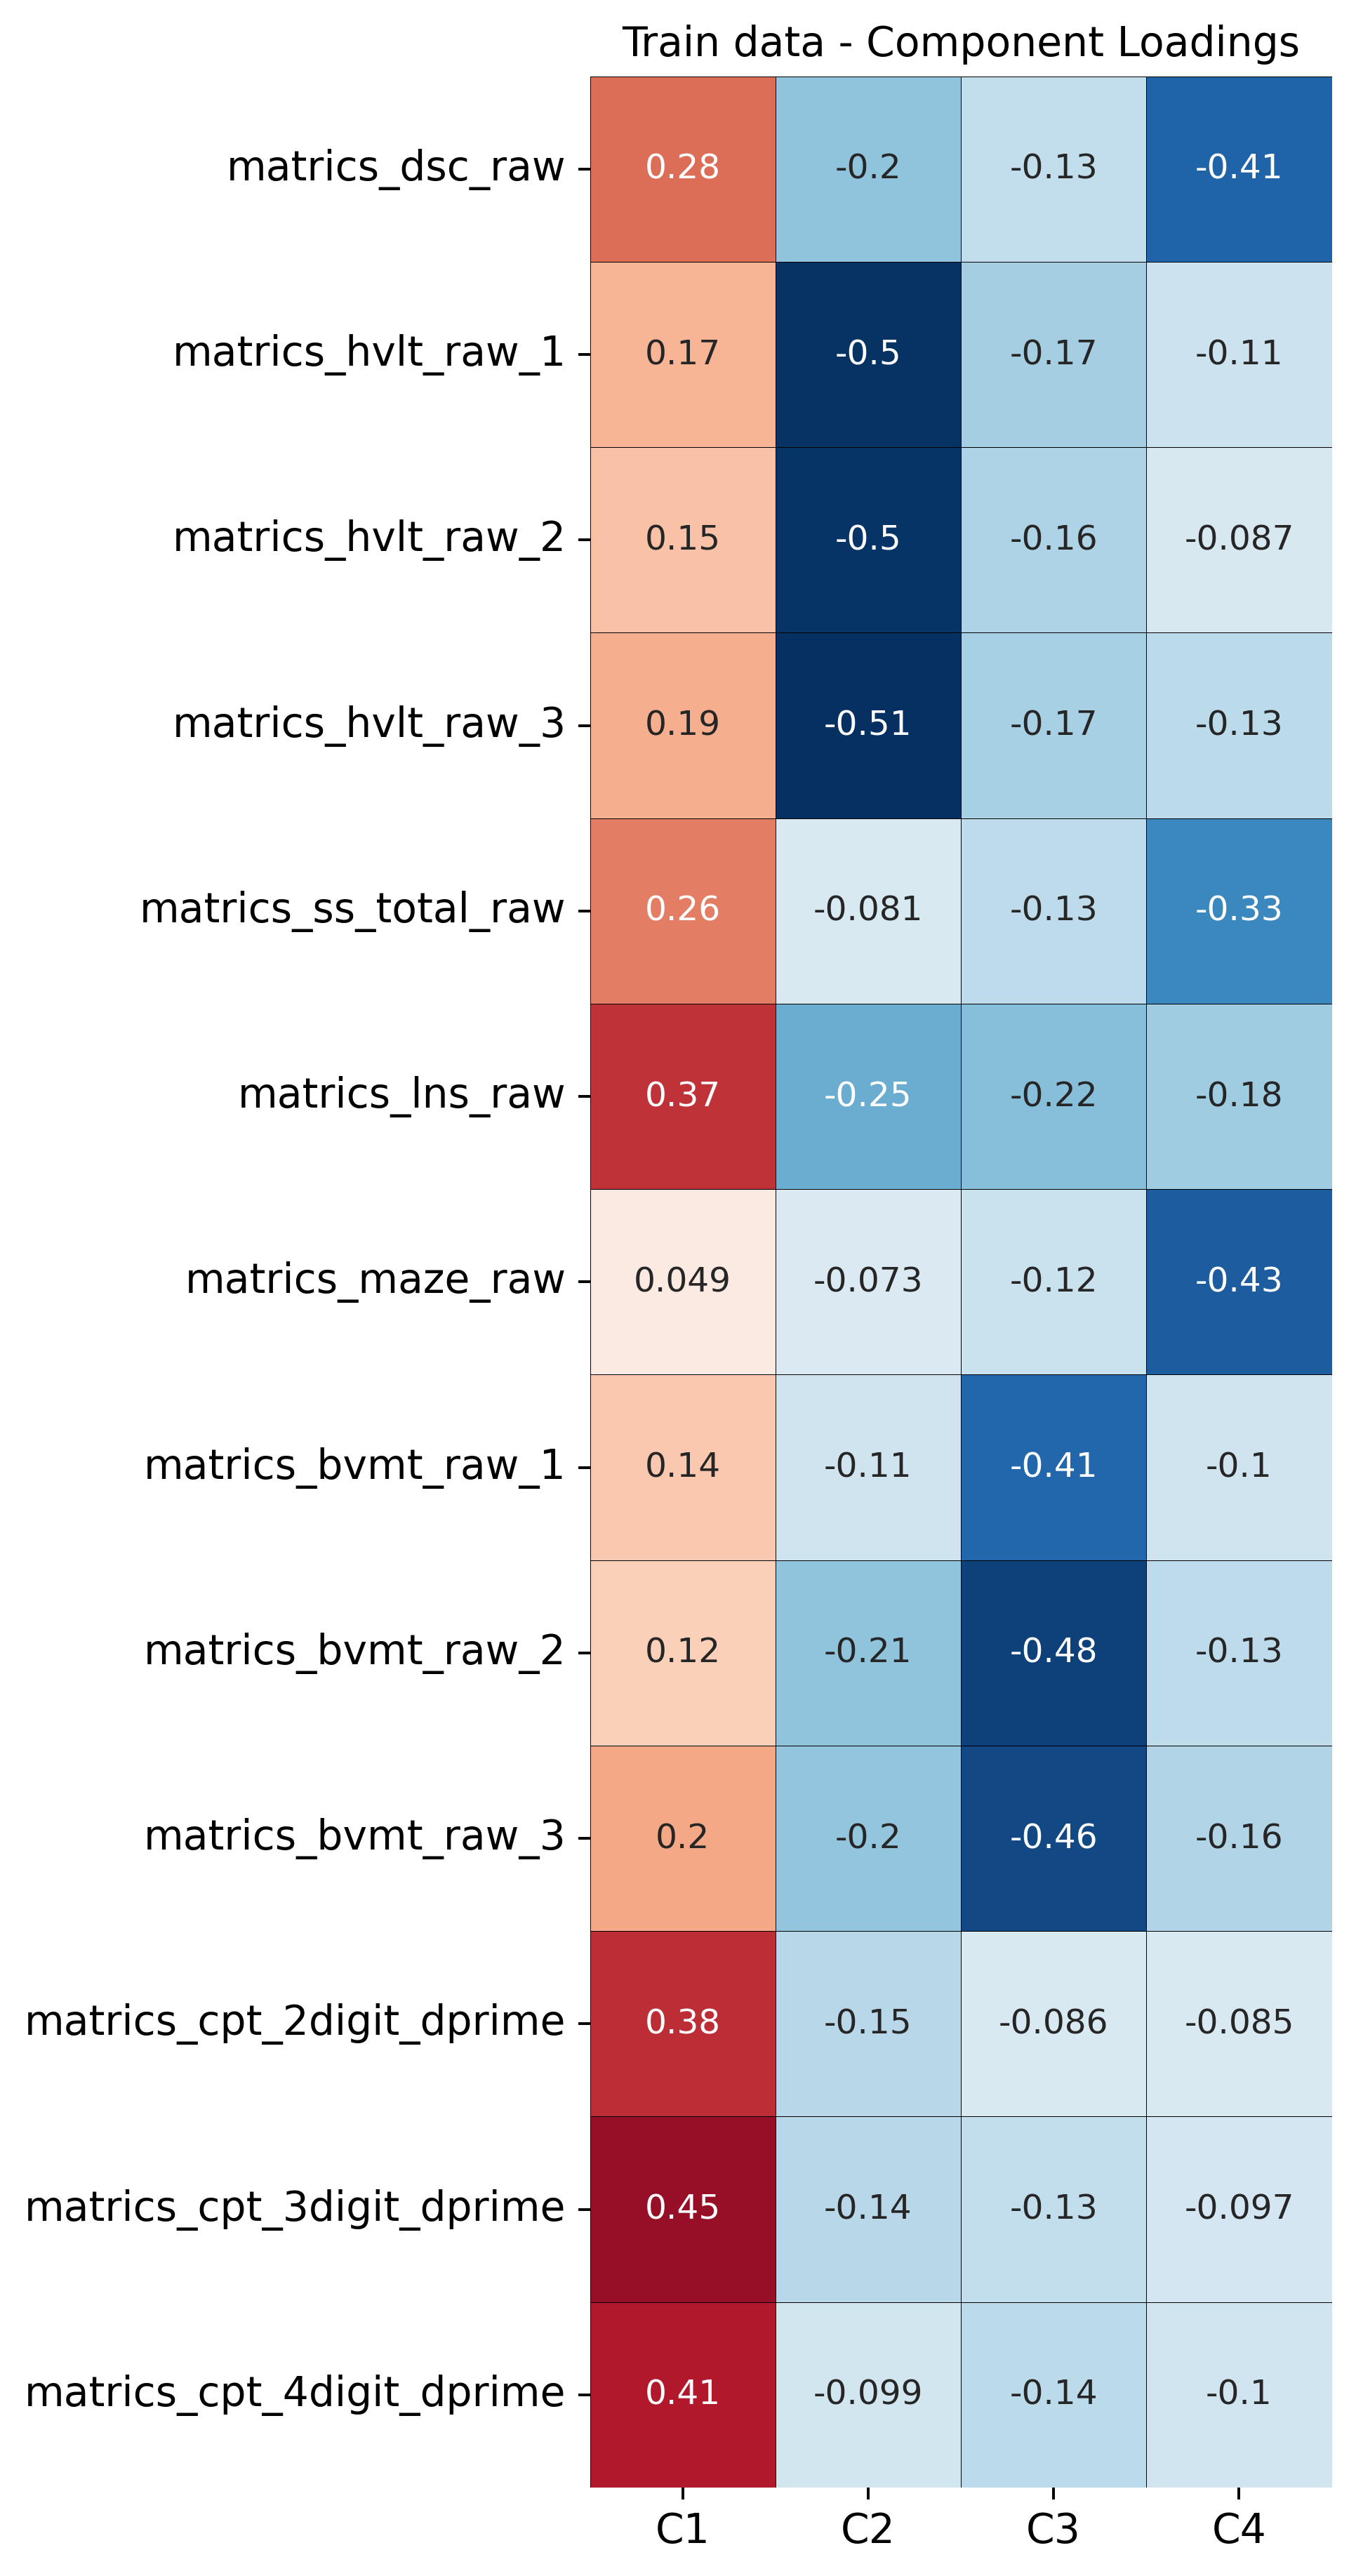

------------------------------------------------------------
------------------------------------------------------------
Train data - Predictor loading threshold - p <= 0.005
Estimated Predictor loading threshold = 0.3310998719068111 (at p<= 0.005 )


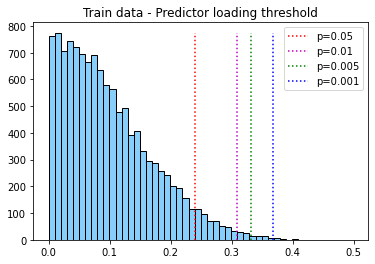

------------------------------------------------------------
------------------------------------------------------------
Train data - Predictor Loadings
Chapter:……


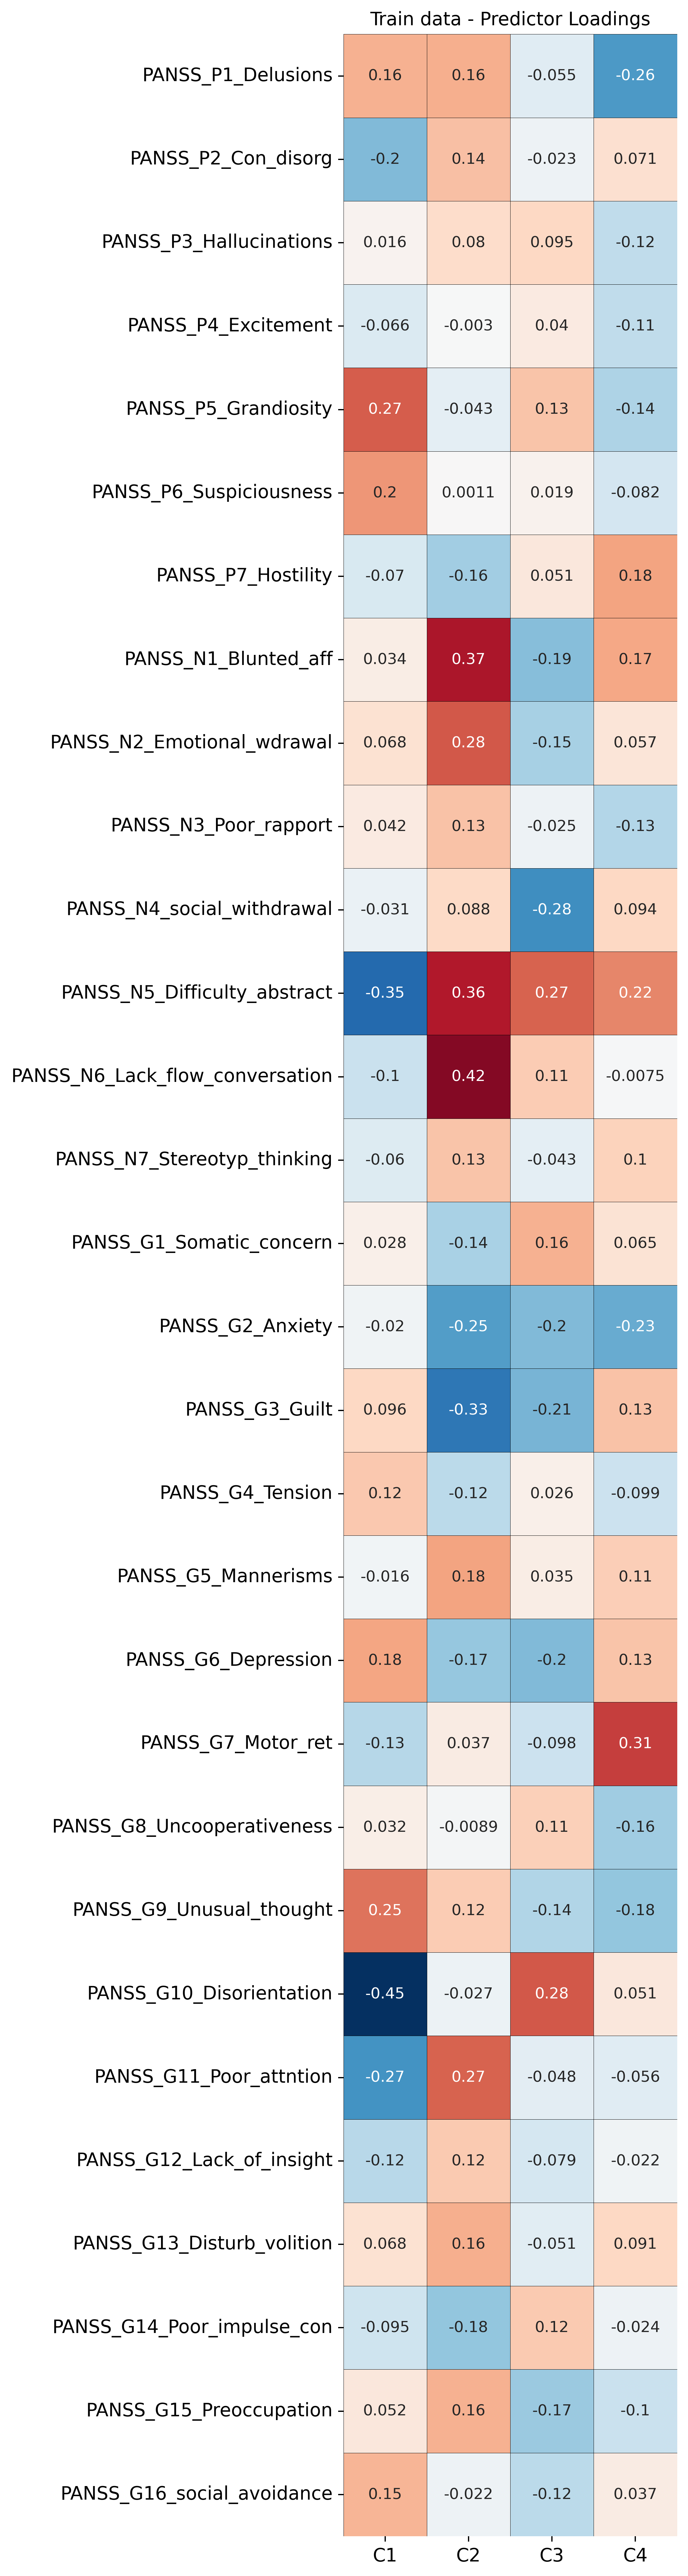

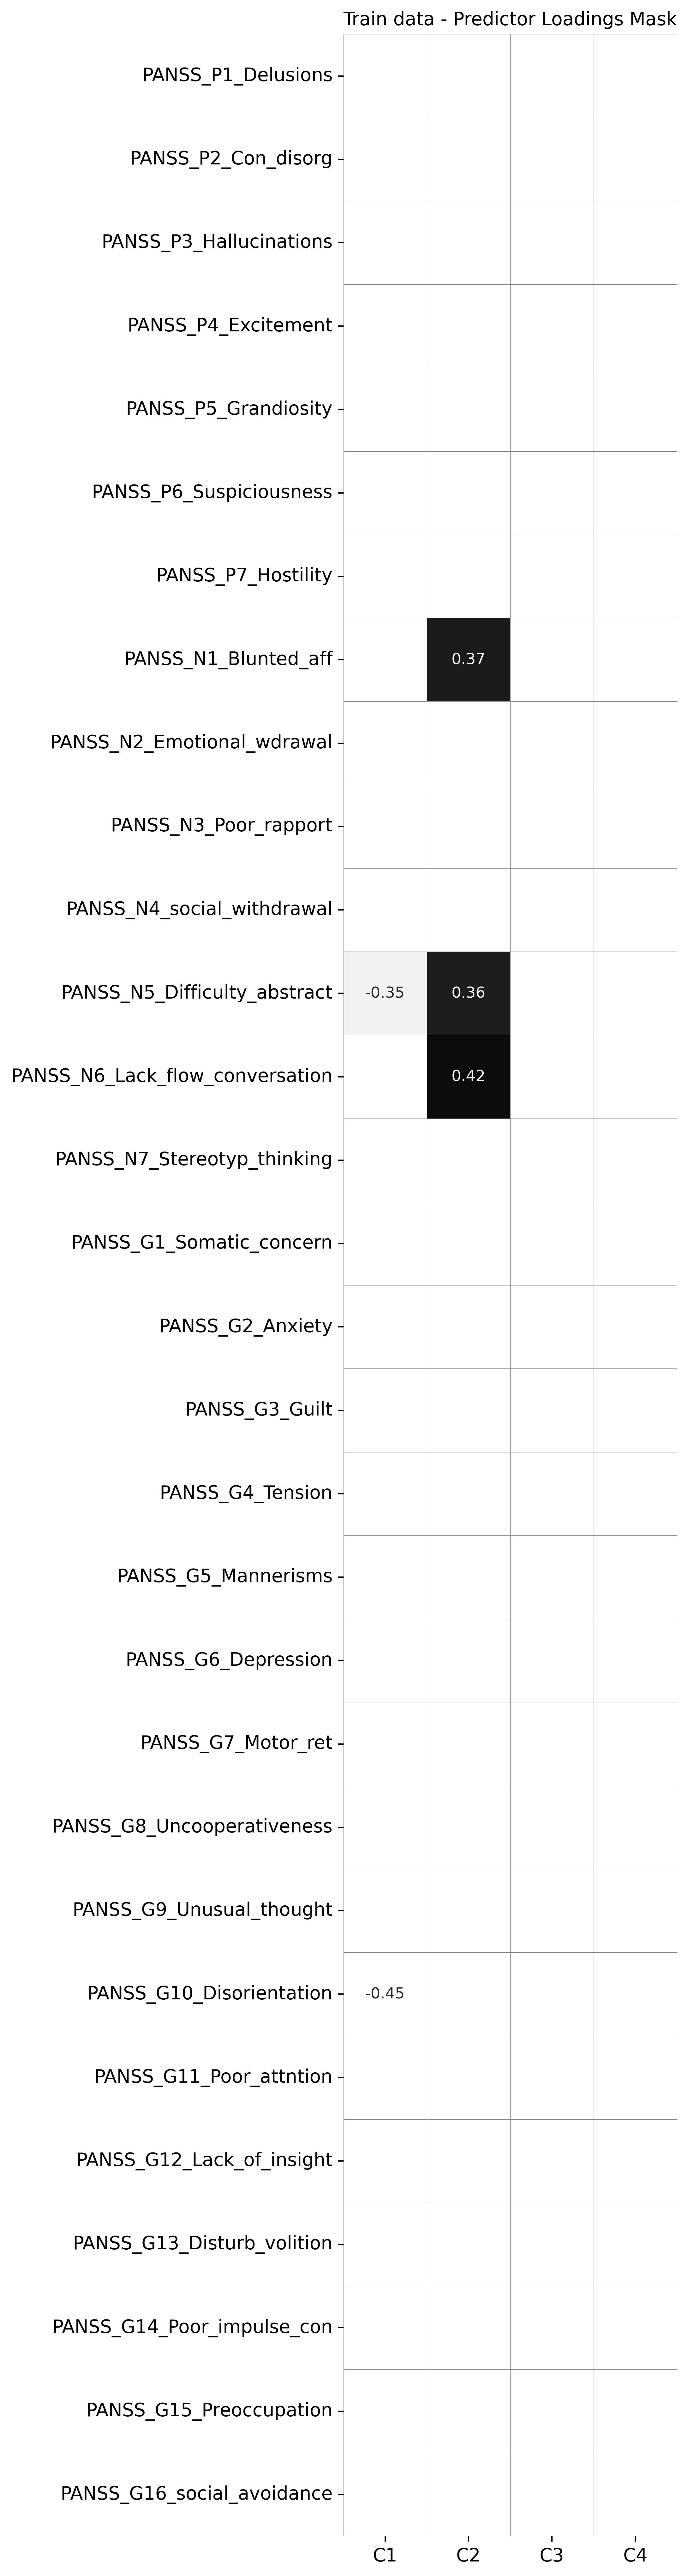

------------------------------------------------------------
------------------------------------------------------------
Train data - Dominant Component Loadings
Chapter:……


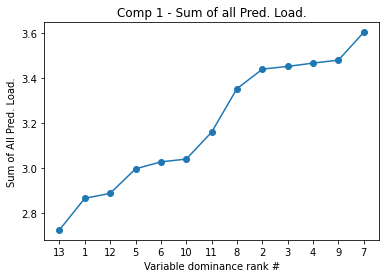

13 matrics_cpt_4digit_dprime
1 matrics_dsc_raw
12 matrics_cpt_3digit_dprime
5 matrics_ss_total_raw
6 matrics_lns_raw
10 matrics_bvmt_raw_3
11 matrics_cpt_2digit_dprime
8 matrics_bvmt_raw_1
2 matrics_hvlt_raw_1
3 matrics_hvlt_raw_2
4 matrics_hvlt_raw_3
9 matrics_bvmt_raw_2
7 matrics_maze_raw


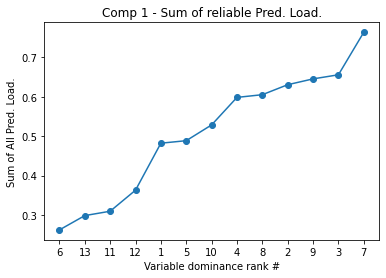

6 matrics_lns_raw
13 matrics_cpt_4digit_dprime
11 matrics_cpt_2digit_dprime
12 matrics_cpt_3digit_dprime
1 matrics_dsc_raw
5 matrics_ss_total_raw
10 matrics_bvmt_raw_3
4 matrics_hvlt_raw_3
8 matrics_bvmt_raw_1
2 matrics_hvlt_raw_1
9 matrics_bvmt_raw_2
3 matrics_hvlt_raw_2
7 matrics_maze_raw


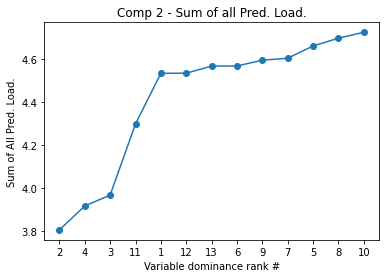

2 matrics_hvlt_raw_1
4 matrics_hvlt_raw_3
3 matrics_hvlt_raw_2
11 matrics_cpt_2digit_dprime
1 matrics_dsc_raw
12 matrics_cpt_3digit_dprime
13 matrics_cpt_4digit_dprime
6 matrics_lns_raw
9 matrics_bvmt_raw_2
7 matrics_maze_raw
5 matrics_ss_total_raw
8 matrics_bvmt_raw_1
10 matrics_bvmt_raw_3


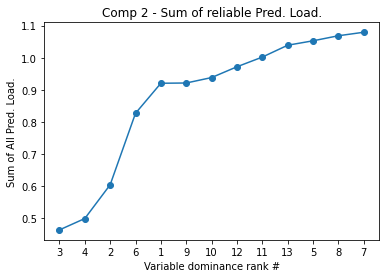

3 matrics_hvlt_raw_2
4 matrics_hvlt_raw_3
2 matrics_hvlt_raw_1
6 matrics_lns_raw
1 matrics_dsc_raw
9 matrics_bvmt_raw_2
10 matrics_bvmt_raw_3
12 matrics_cpt_3digit_dprime
11 matrics_cpt_2digit_dprime
13 matrics_cpt_4digit_dprime
5 matrics_ss_total_raw
8 matrics_bvmt_raw_1
7 matrics_maze_raw
------------------------------------------------------------
------------------------------------------------------------


Number of Variables for Component 1: 4
Number of Variables for Component 2: 3


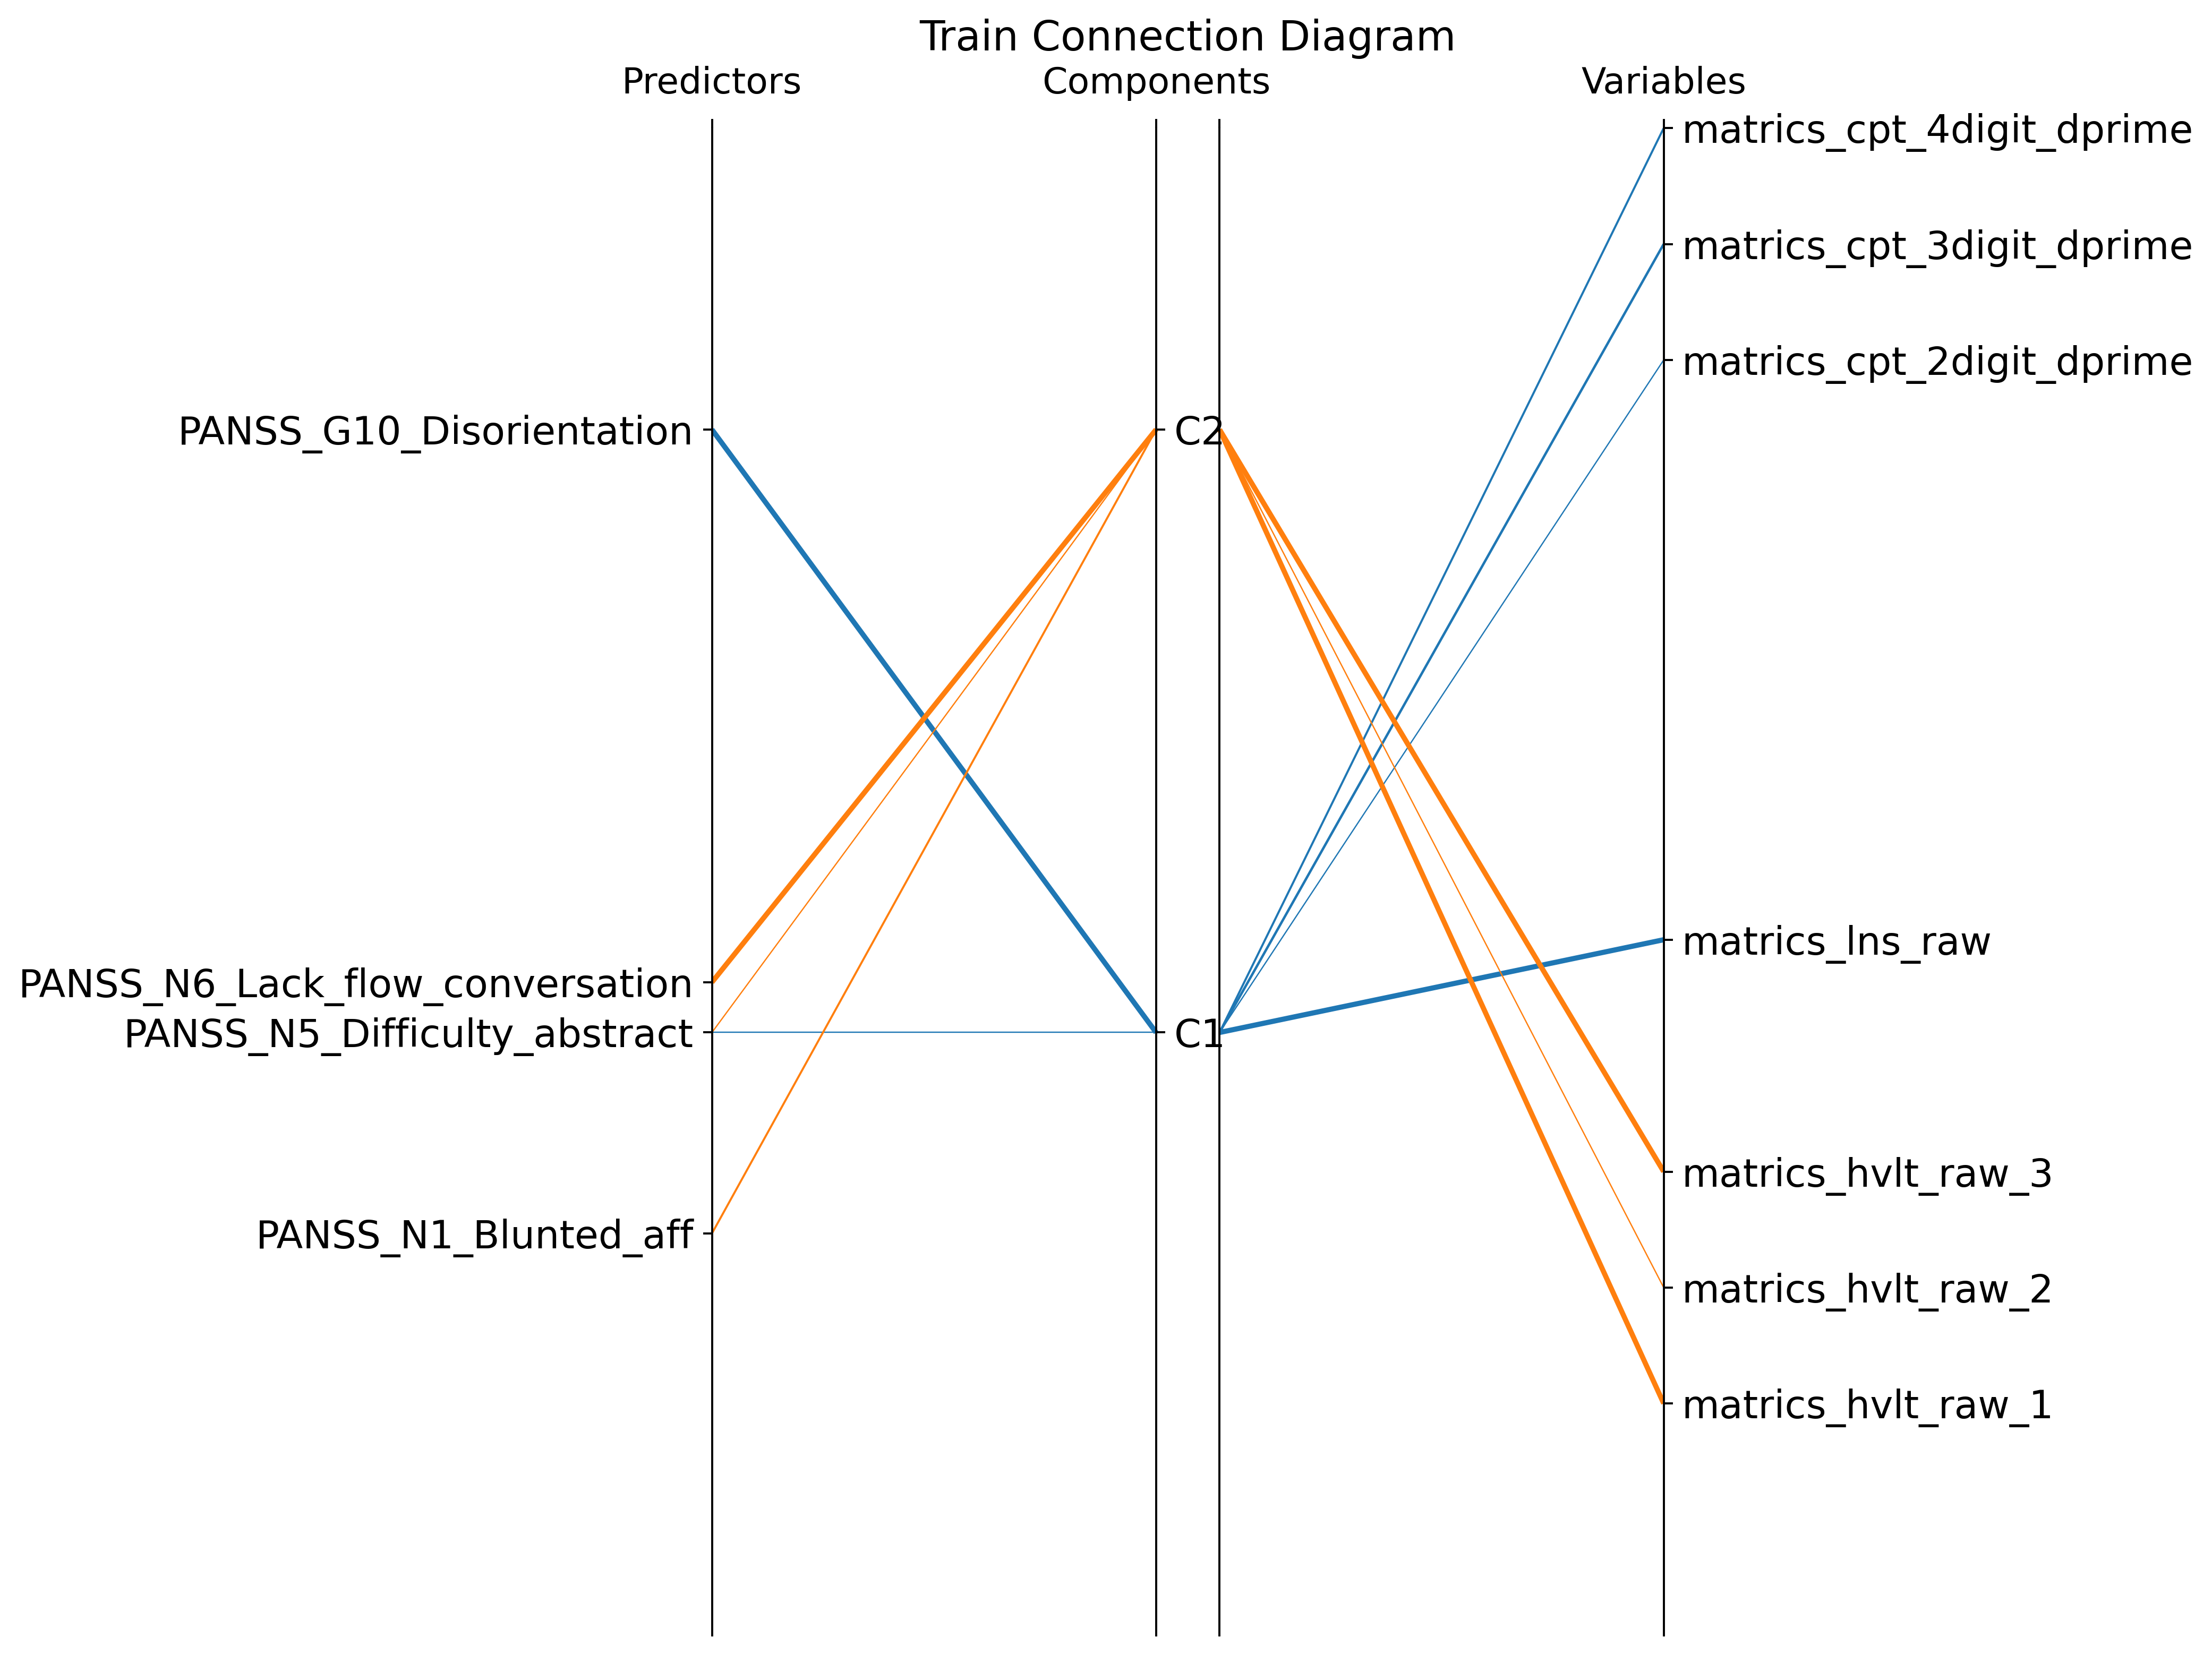

------------------------------------------------------------
------------------------------------------------------------
Test data - Component Loadings
Chapter:……


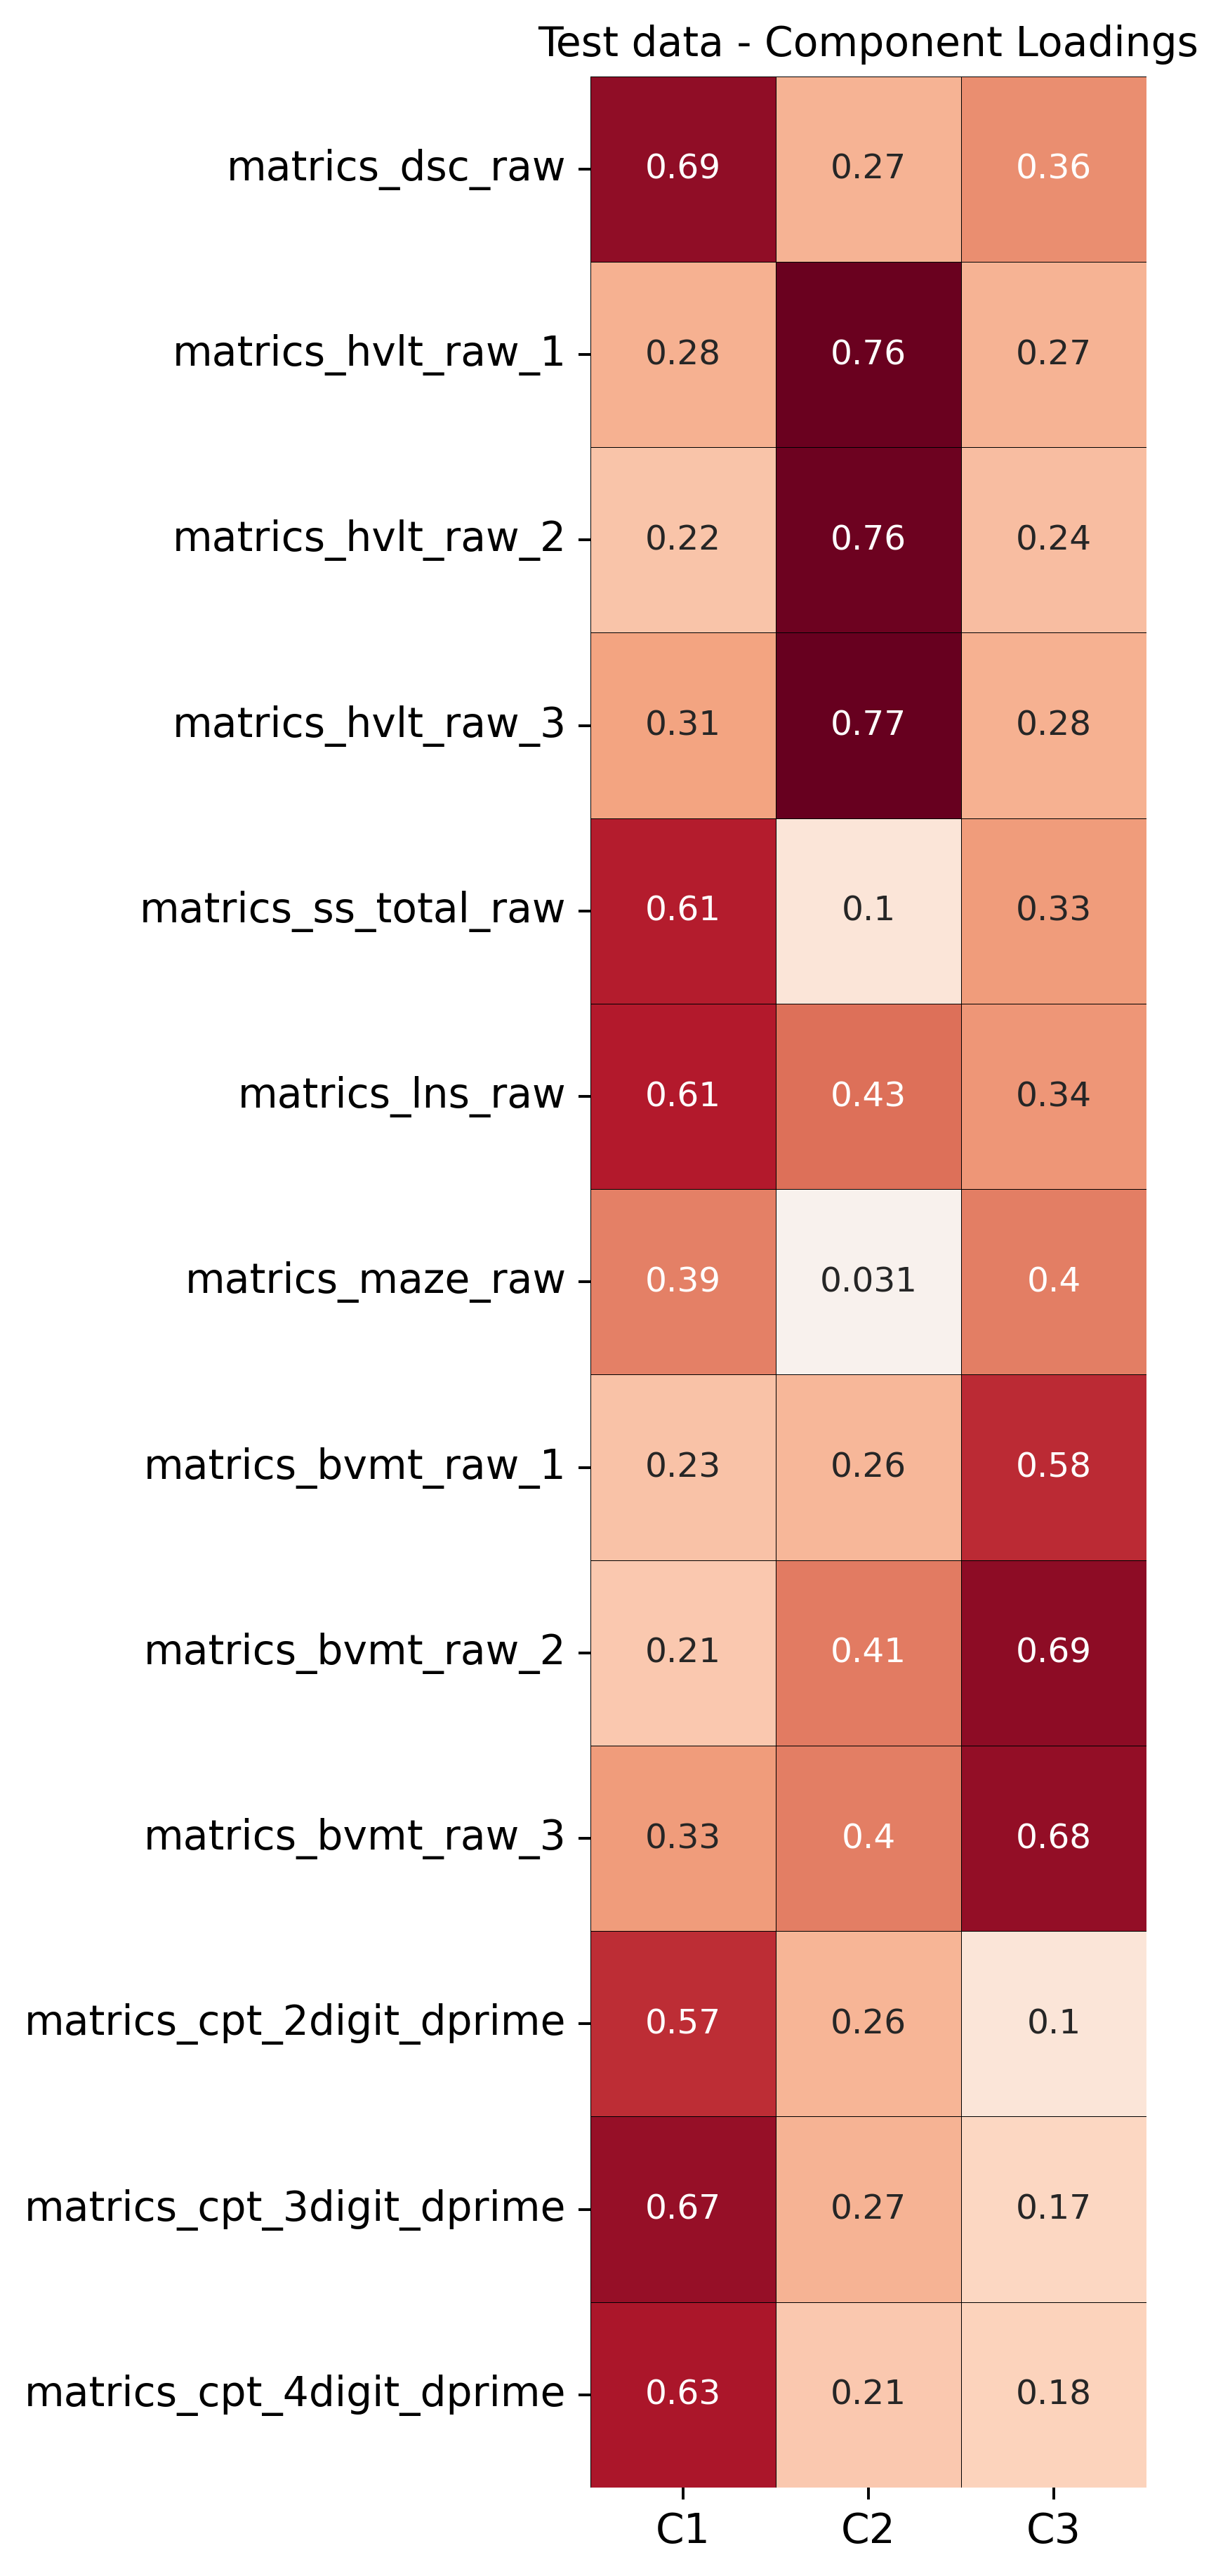

------------------------------------------------------------
------------------------------------------------------------
Test data - Predictor loading threshold - p <= 0.005
Estimated Predictor loading threshold = 0.15674846664676292 (at p<= 0.005 )


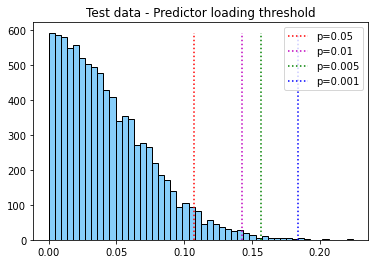

------------------------------------------------------------
------------------------------------------------------------
Test data - Predictor Loadings
Chapter:……


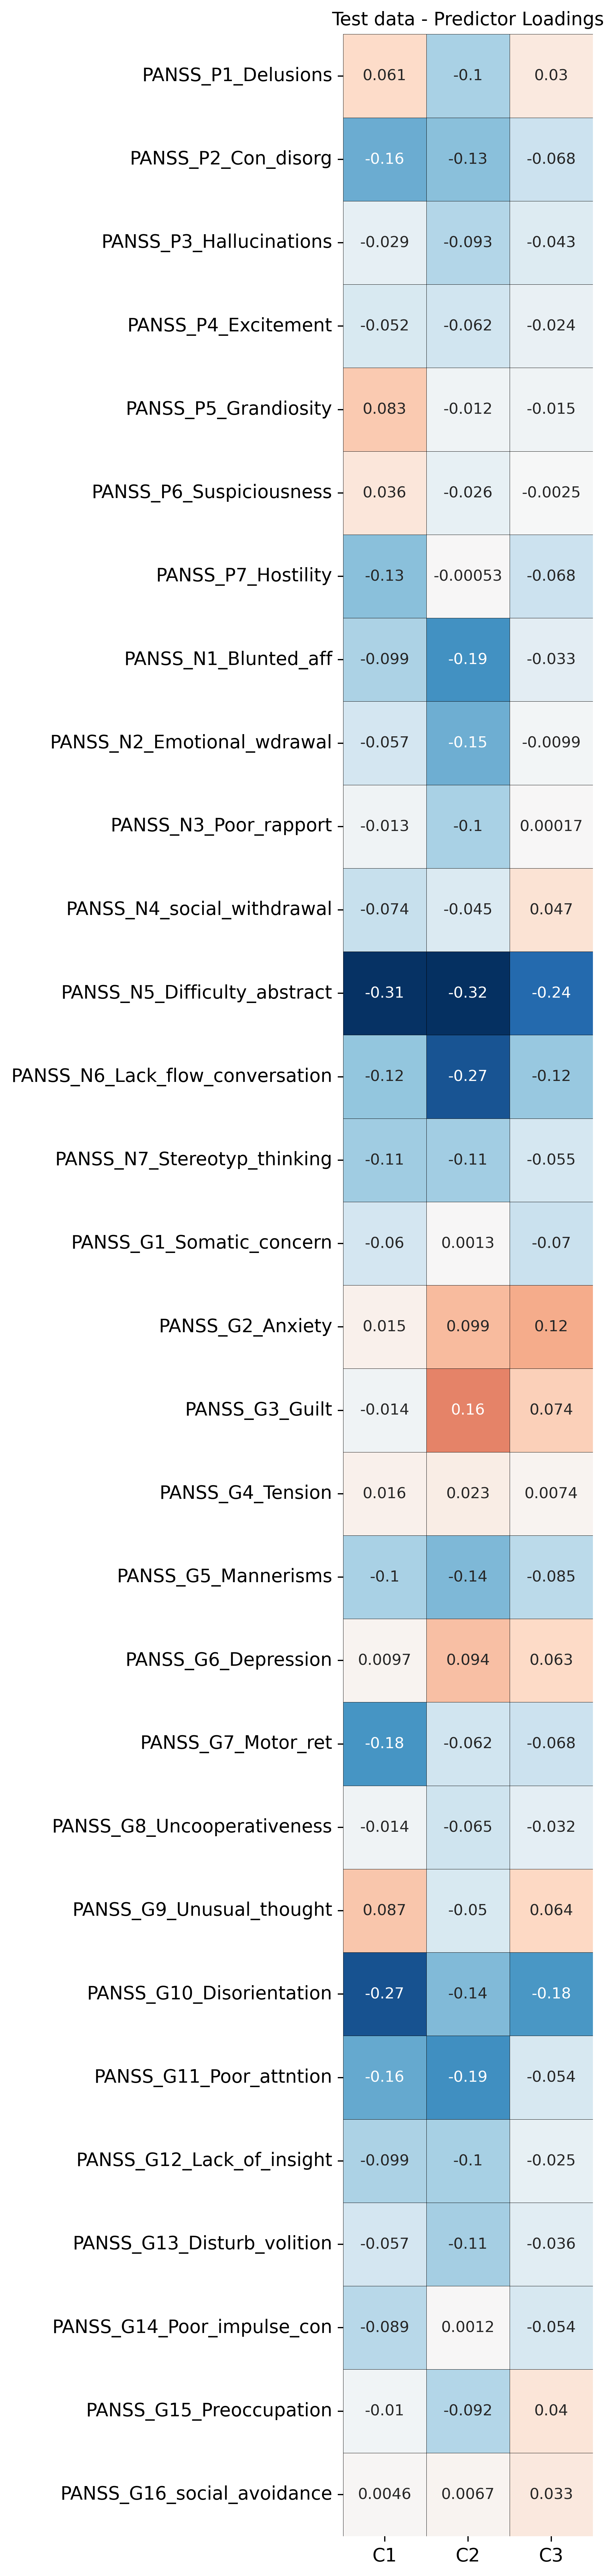

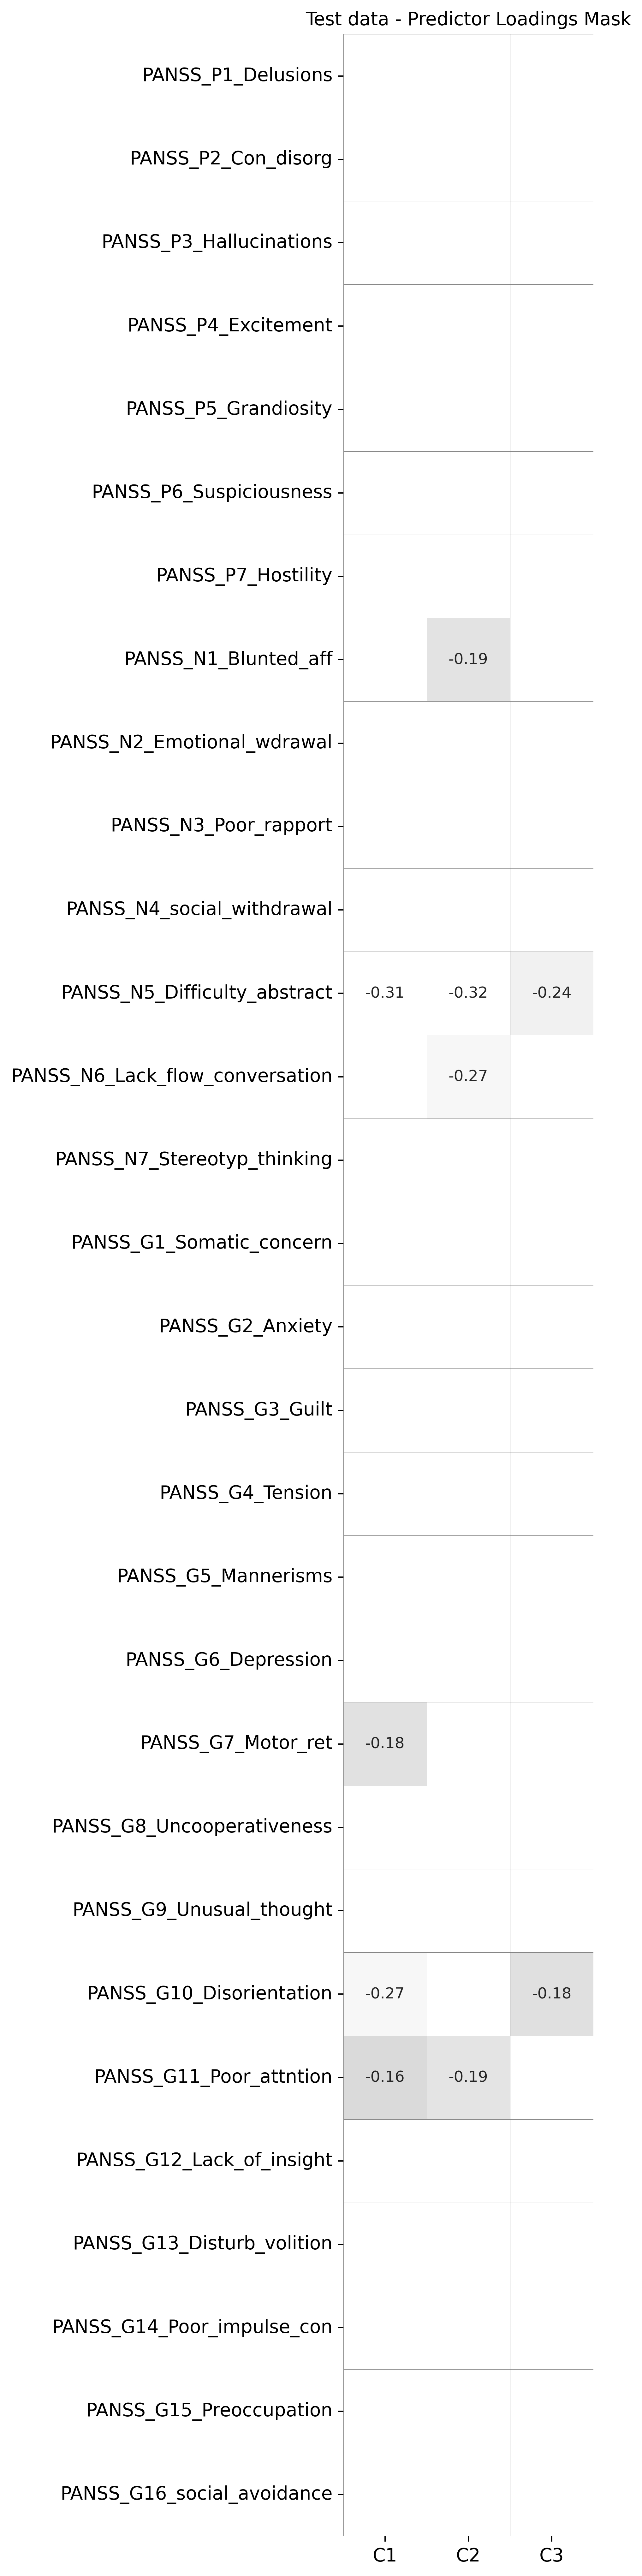

------------------------------------------------------------
------------------------------------------------------------
Test data - Predictor
Test data - Dominant Component Loadings
Chapter:……


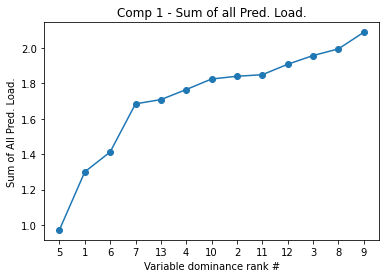

5 matrics_ss_total_raw
1 matrics_dsc_raw
6 matrics_lns_raw
7 matrics_maze_raw
13 matrics_cpt_4digit_dprime
4 matrics_hvlt_raw_3
10 matrics_bvmt_raw_3
2 matrics_hvlt_raw_1
11 matrics_cpt_2digit_dprime
12 matrics_cpt_3digit_dprime
3 matrics_hvlt_raw_2
8 matrics_bvmt_raw_1
9 matrics_bvmt_raw_2


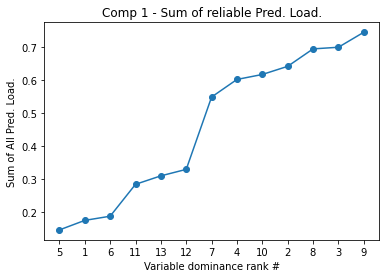

5 matrics_ss_total_raw
1 matrics_dsc_raw
6 matrics_lns_raw
11 matrics_cpt_2digit_dprime
13 matrics_cpt_4digit_dprime
12 matrics_cpt_3digit_dprime
7 matrics_maze_raw
4 matrics_hvlt_raw_3
10 matrics_bvmt_raw_3
2 matrics_hvlt_raw_1
8 matrics_bvmt_raw_1
3 matrics_hvlt_raw_2
9 matrics_bvmt_raw_2


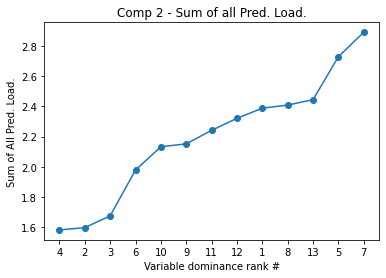

4 matrics_hvlt_raw_3
2 matrics_hvlt_raw_1
3 matrics_hvlt_raw_2
6 matrics_lns_raw
10 matrics_bvmt_raw_3
9 matrics_bvmt_raw_2
11 matrics_cpt_2digit_dprime
12 matrics_cpt_3digit_dprime
1 matrics_dsc_raw
8 matrics_bvmt_raw_1
13 matrics_cpt_4digit_dprime
5 matrics_ss_total_raw
7 matrics_maze_raw


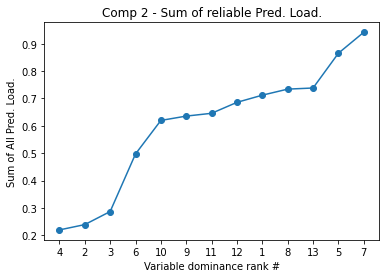

4 matrics_hvlt_raw_3
2 matrics_hvlt_raw_1
3 matrics_hvlt_raw_2
6 matrics_lns_raw
10 matrics_bvmt_raw_3
9 matrics_bvmt_raw_2
11 matrics_cpt_2digit_dprime
12 matrics_cpt_3digit_dprime
1 matrics_dsc_raw
8 matrics_bvmt_raw_1
13 matrics_cpt_4digit_dprime
5 matrics_ss_total_raw
7 matrics_maze_raw


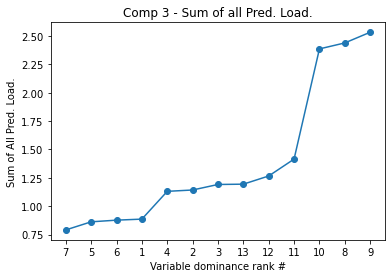

7 matrics_maze_raw
5 matrics_ss_total_raw
6 matrics_lns_raw
1 matrics_dsc_raw
4 matrics_hvlt_raw_3
2 matrics_hvlt_raw_1
3 matrics_hvlt_raw_2
13 matrics_cpt_4digit_dprime
12 matrics_cpt_3digit_dprime
11 matrics_cpt_2digit_dprime
10 matrics_bvmt_raw_3
8 matrics_bvmt_raw_1
9 matrics_bvmt_raw_2


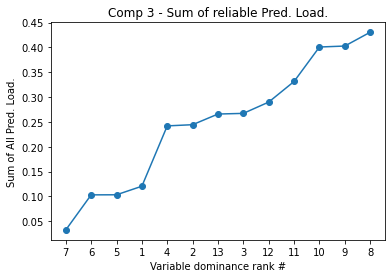

7 matrics_maze_raw
6 matrics_lns_raw
5 matrics_ss_total_raw
1 matrics_dsc_raw
4 matrics_hvlt_raw_3
2 matrics_hvlt_raw_1
13 matrics_cpt_4digit_dprime
3 matrics_hvlt_raw_2
12 matrics_cpt_3digit_dprime
11 matrics_cpt_2digit_dprime
10 matrics_bvmt_raw_3
9 matrics_bvmt_raw_2
8 matrics_bvmt_raw_1
------------------------------------------------------------
------------------------------------------------------------


Number of Variables for Component 1: 3
Number of Variables for Component 2: 3
Number of Variables for Component 3: 4


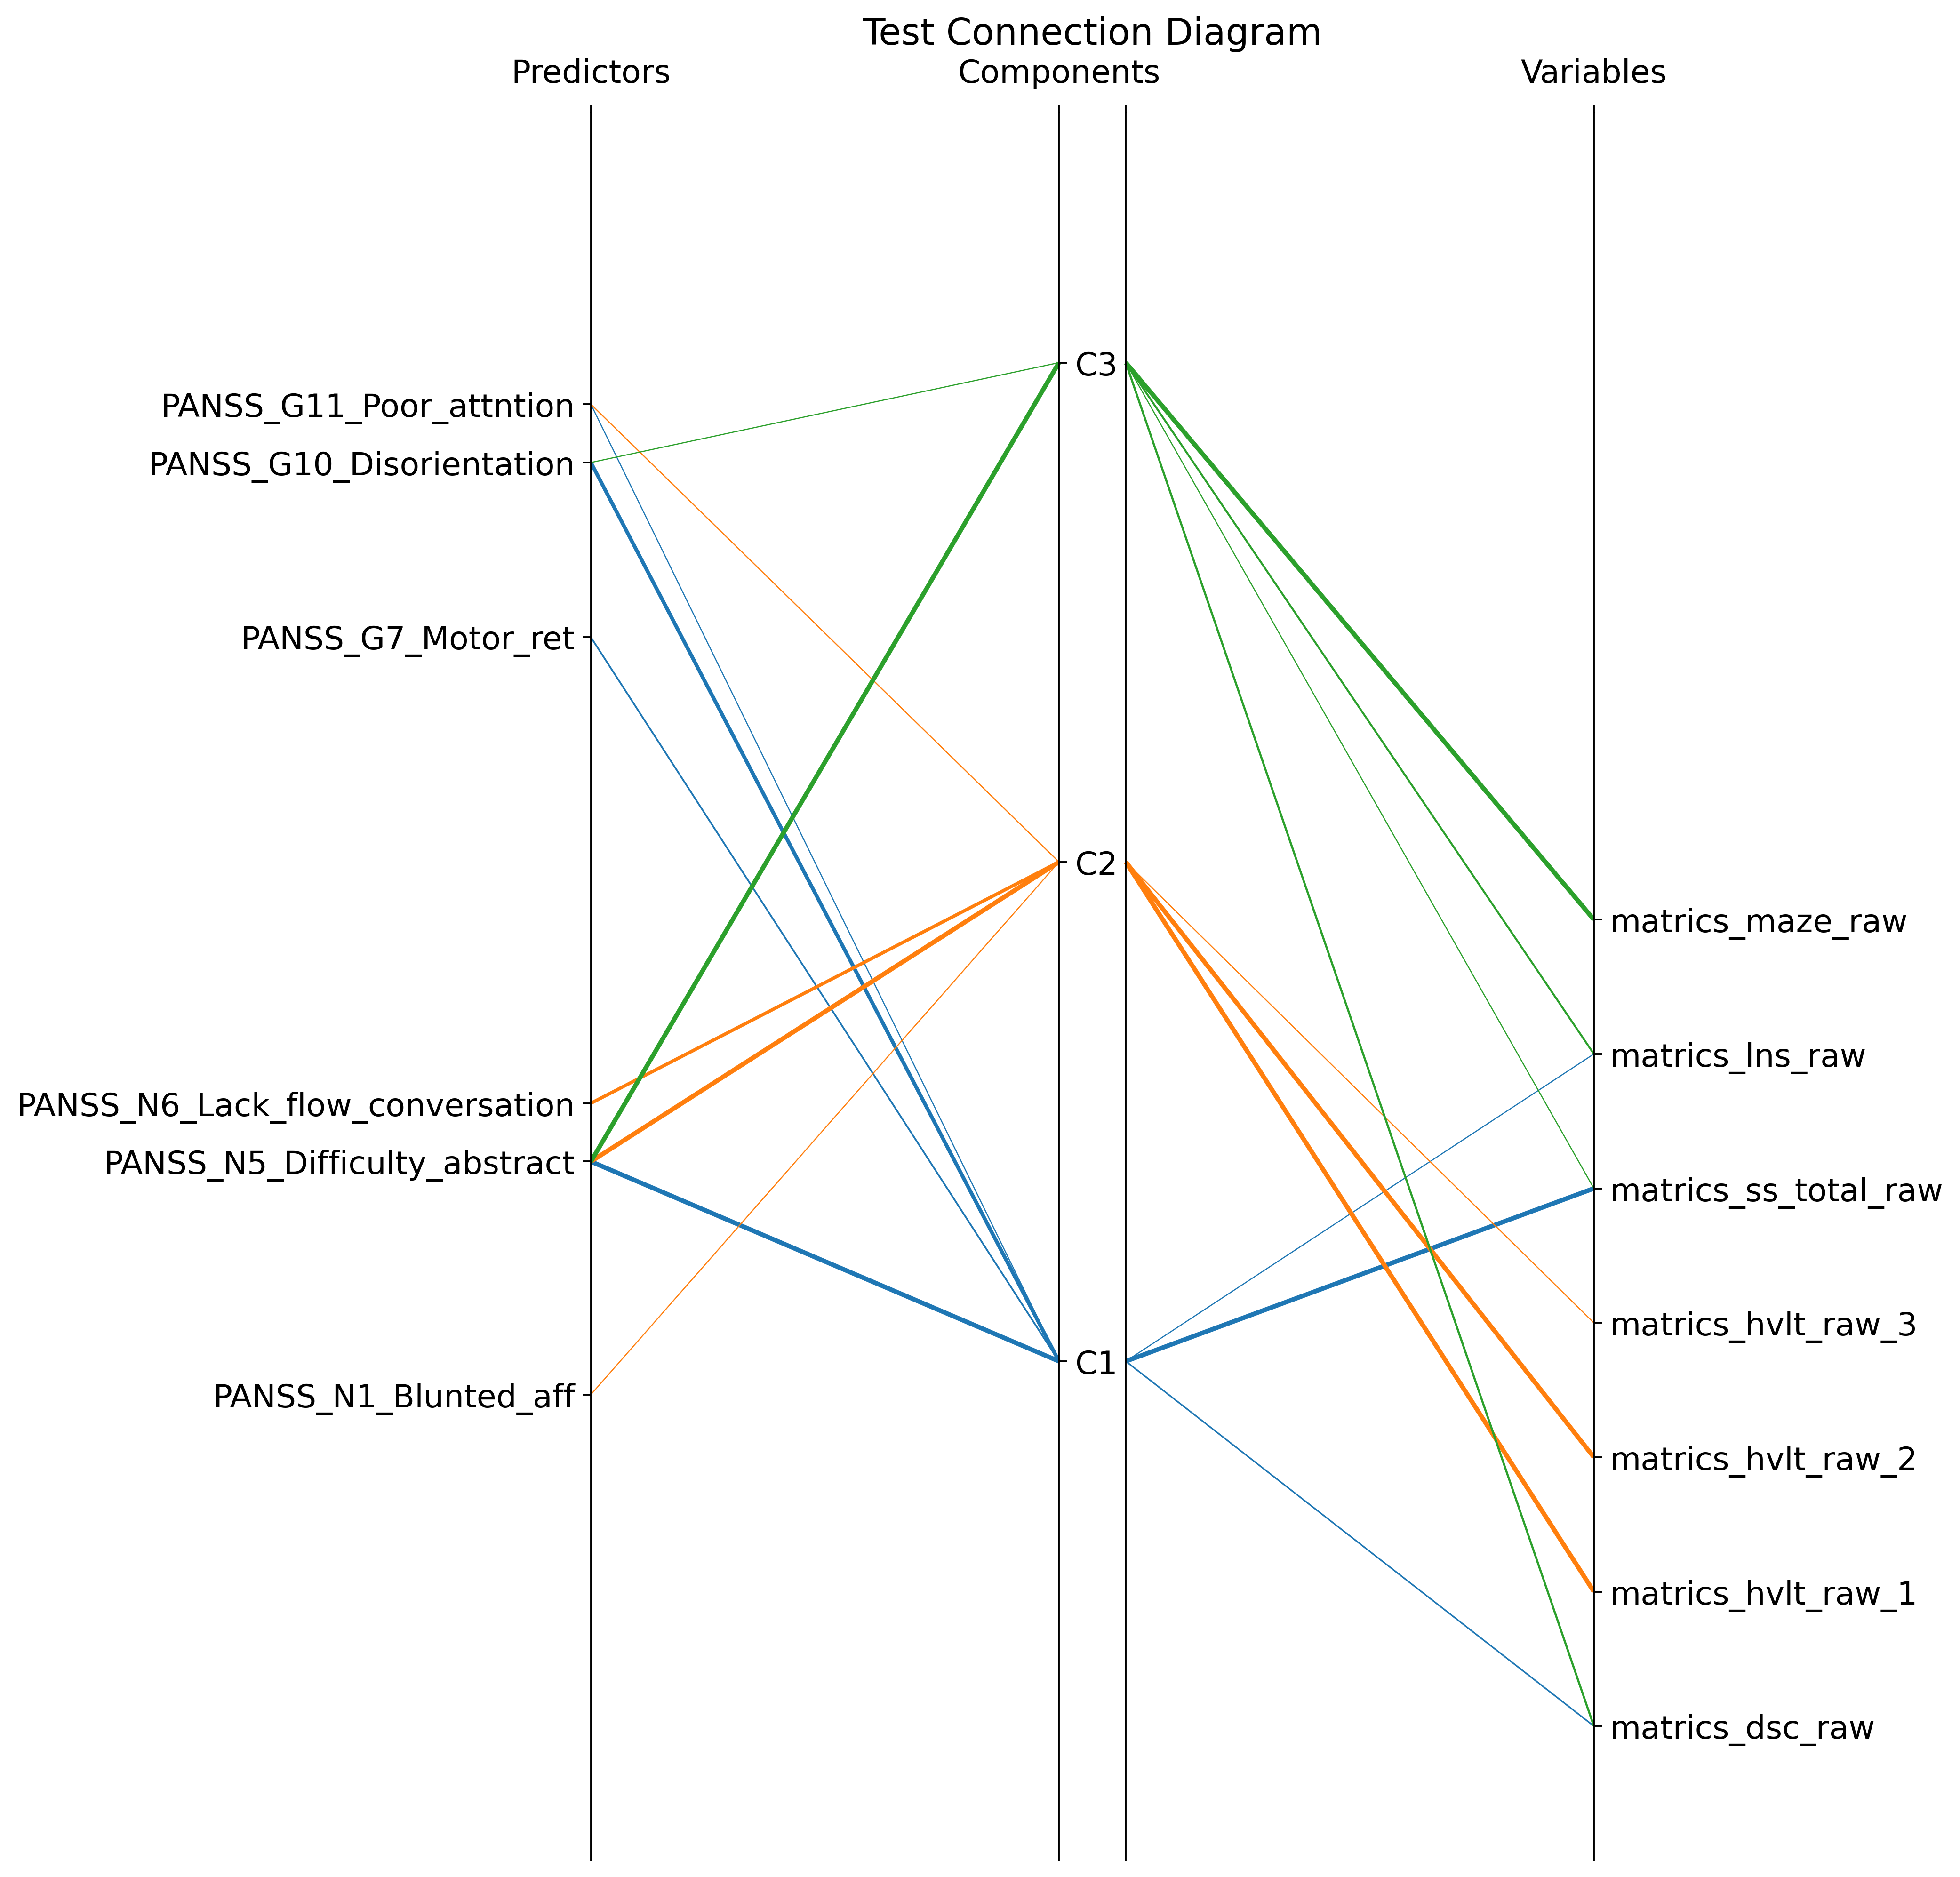

------------------------------------------------------------


In [30]:
##generate the report!
#Train:
print('------------------------------------------------------------')
print('Train data - Component Loadings')
print('Chapter:……')
temp = BH_PCA_train['loadings_VD_sqrtN_GH']
n_Z,n_C = np.shape(temp)
x_ticks=list()
y_ticks=Z_label
for i in range(0,n_C):
    list.append(x_ticks,"C%d"%(i+1))
plt.figure(dpi=350,figsize=(n_C*4,n_Z))
h=sns.heatmap(temp,annot=True,cmap='RdBu_r', center=0,xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='black',square=True,cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Train data - Component Loadings')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Train data - Predictor loading threshold - p <=',params['p_val'])
print('Estimated Predictor loading threshold =',BH_PCA_train['predrel_cutoff'],'(at p<=',params['p_val'],')')
predRel=list()
ppm_shape=np.shape(BH_PCA_train['permutePCorrMean'])
for i in range(ppm_shape[2]):
    for j in range(ppm_shape[1]):
        for k in range(ppm_shape[0]):
            list.append(predRel,abs(BH_PCA_train['permutePCorrMean'][k,j,i]))
his=plt.hist(predRel,bins=50,color='lightskyblue',edgecolor='k')
plt.vlines(np.quantile(predRel, 1-0.05,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='r',linestyles='dotted',label='p=0.05')
plt.vlines(np.quantile(predRel, 1-0.01,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='m',linestyles='dotted',label='p=0.01')
plt.vlines(np.quantile(predRel, 1-0.005,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='g',linestyles='dotted',label='p=0.005')
plt.vlines(np.quantile(predRel, 1-0.001,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='b',linestyles='dotted',label='p=0.001')
plt.legend()
plt.title('Train data - Predictor loading threshold')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Train data - Predictor Loadings')
print('Chapter:……')
temp = BH_PCA_train['meanPCorr']
n_Z,n_C = np.shape(temp)
x_ticks=list()
y_ticks=G_label
for i in range(0,n_C):
    list.append(x_ticks,"C%d"%(i+1))
plt.figure(dpi=350,figsize=(n_C*4,n_Z))
h=sns.heatmap(temp,annot=True,cmap='RdBu_r',center=0,xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='black',square=True,cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Train data - Predictor Loadings')
plt.show()
mask=~BH_PCA_train['RelPredLoadMask']
plt.figure(dpi=350,figsize=(n_C*4,n_Z))
h=sns.heatmap(temp,annot=True,cmap='Greys',center=0,xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='grey',mask=mask,square=True,cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Train data - Predictor Loadings Mask')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
BH_PCA_train['Res']=SelectCompLoadingsBig(BH_PCA_train, params)
print('Train data - Dominant Component Loadings')
print('Chapter:……')
comp_rel=np.where(sum(BH_PCA_train['RelPredLoadMask']))
sumPredLoad=BH_PCA_train['Res']['0']['SumPredLoad']
for ii in range(1,len(BH_PCA_train['Res'])):
    sumPredLoad=np.row_stack((sumPredLoad,BH_PCA_train['Res'][str(ii)]['SumPredLoad']))
sumPredLoadRel=BH_PCA_train['Res']['0']['SumPredLoadRel']
for ii in range(1,len(BH_PCA_train['Res'])):
    sumPredLoadRel=np.row_stack((sumPredLoadRel,BH_PCA_train['Res'][str(ii)]['SumPredLoadRel']))
sumPredLoadSort=np.zeros(np.shape(sumPredLoad))
sumPredLoadSortIdx=np.zeros(np.shape(sumPredLoad))
for ii in range(np.shape(sumPredLoad)[1]):
    sumPredLoadSort[:,ii] = sorted(sumPredLoad[:,ii])
    sumPredLoadSortIdx[:,ii] = sorted(range(len(sumPredLoad[:,ii])), key = lambda x:sumPredLoad[x,ii])
sumPredLoadRelSort=np.zeros(np.shape(sumPredLoadRel))
sumPredLoadRelSortIdx=np.zeros(np.shape(sumPredLoadRel))
for ii in range(np.shape(sumPredLoadRel)[1]):
    sumPredLoadRelSort[:,ii] = sorted(sumPredLoadRel[:,ii])
    sumPredLoadRelSortIdx[:,ii] = sorted(range(len(sumPredLoadRel[:,ii])), key = lambda x:sumPredLoadRel[x,ii])
for ii in comp_rel[0]:
    plt.figure()
    s = plt.plot(np.arange(np.shape(sumPredLoadSort)[0]),sumPredLoadSort[:,ii],'o-')
    xticks=list()
    for i in range(np.shape(sumPredLoadSortIdx)[0]):
        list.append(xticks,str(int(sumPredLoadSortIdx[i,ii]+1)))
    plt.xlabel('Variable dominance rank #')
    plt.xticks(np.arange(np.shape(sumPredLoadSort)[0]),xticks)
    plt.ylabel('Sum of All Pred. Load.')
    plt.title('Comp %d - Sum of all Pred. Load.'%(ii+1))
    plt.show()
    for i in range(len(xticks)):
        print(xticks[i], Z_label[int(xticks[i])-1])
    plt.figure()
    s = plt.plot(np.arange(np.shape(sumPredLoadRelSort)[0]),sumPredLoadRelSort[:,ii],'o-')
    xticks=list()
    for i in range(np.shape(sumPredLoadRelSortIdx)[0]):
        list.append(xticks,str(int(sumPredLoadRelSortIdx[i,ii]+1)))
    plt.xlabel('Variable dominance rank #')
    plt.xticks(np.arange(np.shape(sumPredLoadRelSort)[0]),xticks)
    plt.ylabel('Sum of All Pred. Load.')
    plt.title('Comp %d - Sum of reliable Pred. Load.'%(ii+1))
    plt.show()
    for i in range(len(xticks)):
        print(xticks[i], Z_label[int(xticks[i])-1])
print('------------------------------------------------------------')
print('------------------------------------------------------------')
comp_rel=np.where(sum(BH_PCA_train['RelPredLoadMask']))
#parallel coordinates plot
fig, host = plt.subplots(dpi=350,figsize=(12,4+np.size(comp_rel)*2.5))
ynames = ['Predictors','Components',' ','Variables']
ymins=[0,0,0,0]
ymaxs=[np.shape(BH_PCA_train['PCorr'])[0],np.size(comp_rel)+0.5,np.size(comp_rel)+0.5,np.shape(BH_PCA_train['loadings_VD_sqrtN_GH'])[0]]
axes = [host] + [host.twinx() for i in range(3)]
category=np.arange(BH_PCA_train['nComp'])
host.set_xlim(0,3)
host.set_xticks([0,1.4,1.6,3])
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('Train Connection Diagram', fontsize=16)
colors = plt.cm.tab10.colors
n_vdom=np.zeros((BH_PCA_train['nComp'],1))
n_vdom=n_vdom.astype(np.int32)
lwmax=2
lwmin=0.5
c_flag=0
pred_yticks=list()
var_yticks=list()
comp_yticks=list()
comp_ytcks_labels=list()
pred_ytcks_labels=list()
var_ytcks_labels=list()
for ii in comp_rel[0]:
    c_flag=c_flag+1
    n_vdom[ii,0]=input('Number of Variables for Component %d:'%(ii+1))
    vDom=list()
    vDomVal=list()
    sPred=list()
    sPredVal=list()
    for i in range(np.shape(BH_PCA_train['PCorr'])[0]):
        if(BH_PCA_train['RelPredLoadMask'][i,ii]==True):
            list.append(sPred,int(i+1))
            list.append(pred_yticks,int(i+1))
            list.append(sPredVal,abs(BH_PCA_train['meanPCorr'][i,ii]))
    for i in range(n_vdom[ii,0]):
        list.append(vDom,int(sumPredLoadRelSortIdx[i,ii]+1))
        list.append(vDomVal,abs(BH_PCA_train['loadings_VD_sqrtN_GH'][i,ii]))
        list.append(var_yticks,int(sumPredLoadRelSortIdx[i,ii]+1))
    if(~np.any(sPred)):
        list.append(sPred,np.nan)
    if(~np.any(vDom)):
        list.append(vDom,np.nan)
    maxVal=max(sPredVal)
    minVal=min(sPredVal)
    lw=list()
    if len(sPred)>1:
        for i in range(len(sPred)):
            list.append(lw,(lwmax-lwmin)*(sPredVal[i]-minVal)/(maxVal-minVal)+lwmin)
    else:
        list.append(lw,1.5)
    for j in range(len(sPred)):
        verts = list(zip([0,1.4],[sPred[j],((c_flag)*ymaxs[0]/ymaxs[1])]))
        codes = [Path.MOVETO] + [Path.LINETO for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=lw[j], edgecolor=colors[category[ii]])
        host.add_patch(patch)
    maxVal=max(vDomVal)
    minVal=min(vDomVal)
    lw=list()
    if len(vDom)>1:
        for i in range(len(vDom)):
            list.append(lw,(lwmax-lwmin)*(vDomVal[i]-minVal)/(maxVal-minVal)+lwmin)
    else:
        list.append(lw,1.5)
    for j in range(len(vDom)):
        verts = list(zip([1.6,3],[((c_flag)*ymaxs[0]/ymaxs[1]),vDom[j]*ymaxs[0]/ymaxs[3]]))
        codes = [Path.MOVETO] + [Path.LINETO for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=lw[j], edgecolor=colors[category[ii]])
        host.add_patch(patch)
    vDom=[]
    vDomVal=[]
    sPred=[]
    sPredVal=[]
    lw=[]
pred_yticks=list(set(pred_yticks))
var_yticks=list(set(var_yticks))
comp_yticks=np.linspace(1,np.size(comp_rel),num=np.size(comp_rel))
for i in range(len(comp_rel[0])):
    list.append(comp_ytcks_labels,"C%d"%(comp_rel[0][i]+1))
for i in range(len(pred_yticks)):
    list.append(pred_ytcks_labels,G_label[pred_yticks[i]-1])#pred_name[i]
for i in range(len(var_yticks)):
    list.append(var_ytcks_labels,Z_label[var_yticks[i]-1])#pred_name[i]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        if i != 1 and i != 2:
            ax.spines["right"].set_position(("axes", i / (3)))
        elif i == 1:
            ax.spines["right"].set_position(("axes", (i+0.4) / (3)))
        else:
            ax.spines["right"].set_position(("axes", (i-0.4) / (3)))
    if i == 1:
        ax.yaxis.set_ticks(comp_yticks,endpoint=True)
        ax.yaxis.set_ticklabels(comp_ytcks_labels,fontsize=15)
    elif i == 0:
        ax.yaxis.set_ticks(pred_yticks,endpoint=True)
        ax.yaxis.set_ticklabels(pred_ytcks_labels,fontsize=15)
    elif i == 3:
        ax.yaxis.set_ticks(var_yticks,endpoint=True)
        ax.yaxis.set_ticklabels(var_ytcks_labels,fontsize=15)
    else:
        ax.yaxis.set_ticks([])
plt.tight_layout()
plt.show()
print('------------------------------------------------------------')
#Test:
##generate the report!
print('------------------------------------------------------------')
print('Test data - Component Loadings')
print('Chapter:……')
temp = BH_PCA_test['loadings_VD_sqrtN_GH']
n_Z,n_C = np.shape(temp)
x_ticks=list()
y_ticks=Z_label
for i in range(0,n_C):
    list.append(x_ticks,"C%d"%(i+1))
plt.figure(dpi=350,figsize=(n_C*4,n_Z))
h=sns.heatmap(temp,annot=True,cmap='RdBu_r',center=0,xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='black',square=True,cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Test data - Component Loadings')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Test data - Predictor loading threshold - p <=',params['p_val'])
print('Estimated Predictor loading threshold =',BH_PCA_test['predrel_cutoff'],'(at p<=',params['p_val'],')')
predRel=list()
ppm_shape=np.shape(BH_PCA_test['permutePCorrMean'])
for i in range(ppm_shape[2]):
    for j in range(ppm_shape[1]):
        for k in range(ppm_shape[0]):
            list.append(predRel,abs(BH_PCA_test['permutePCorrMean'][k,j,i]))
his=plt.hist(predRel,bins=50,color='lightskyblue',edgecolor='k')
plt.vlines(np.quantile(predRel, 1-0.05,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='r',linestyles='dotted',label='p=0.05')
plt.vlines(np.quantile(predRel, 1-0.01,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='m',linestyles='dotted',label='p=0.01')
plt.vlines(np.quantile(predRel, 1-0.005,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='g',linestyles='dotted',label='p=0.005')
plt.vlines(np.quantile(predRel, 1-0.001,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='b',linestyles='dotted',label='p=0.001')
plt.legend()
plt.title('Test data - Predictor loading threshold')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Test data - Predictor Loadings')
print('Chapter:……')
temp = BH_PCA_test['meanPCorr']
n_Z,n_C = np.shape(temp)
x_ticks=list()
y_ticks=G_label
for i in range(0,n_C):
    list.append(x_ticks,"C%d"%(i+1))
plt.figure(dpi=350,figsize=(n_C*4,n_Z))
h=sns.heatmap(temp,annot=True,cmap='RdBu_r',center=0,xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='black',square=True,cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Test data - Predictor Loadings')
plt.show()
mask=~BH_PCA_test['RelPredLoadMask']
plt.figure(dpi=350,figsize=(n_C*4,n_Z))
h=sns.heatmap(temp,annot=True,cmap='Greys',center=0,xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='grey',mask=mask,square=True,cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Test data - Predictor Loadings Mask')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Test data - Predictor') 

BH_PCA_test['Res']=SelectCompLoadingsBig(BH_PCA_test, params)

print('Test data - Dominant Component Loadings')
print('Chapter:……')
comp_rel=np.where(sum(BH_PCA_test['RelPredLoadMask']))
sumPredLoad=BH_PCA_test['Res']['0']['SumPredLoad']
for ii in range(1,len(BH_PCA_test['Res'])):
    sumPredLoad=np.row_stack((sumPredLoad,BH_PCA_test['Res'][str(ii)]['SumPredLoad']))
sumPredLoadRel=BH_PCA_test['Res']['0']['SumPredLoadRel']
for ii in range(1,len(BH_PCA_test['Res'])):
    sumPredLoadRel=np.row_stack((sumPredLoadRel,BH_PCA_test['Res'][str(ii)]['SumPredLoadRel']))
sumPredLoadSort=np.zeros(np.shape(sumPredLoad))
sumPredLoadSortIdx=np.zeros(np.shape(sumPredLoad))
for ii in range(np.shape(sumPredLoad)[1]):
    sumPredLoadSort[:,ii] = sorted(sumPredLoad[:,ii])
    sumPredLoadSortIdx[:,ii] = sorted(range(len(sumPredLoad[:,ii])), key = lambda x:sumPredLoad[x,ii])
sumPredLoadRelSort=np.zeros(np.shape(sumPredLoadRel))
sumPredLoadRelSortIdx=np.zeros(np.shape(sumPredLoadRel))
for ii in range(np.shape(sumPredLoadRel)[1]):
    sumPredLoadRelSort[:,ii] = sorted(sumPredLoadRel[:,ii])
    sumPredLoadRelSortIdx[:,ii] = sorted(range(len(sumPredLoadRel[:,ii])), key = lambda x:sumPredLoadRel[x,ii])
for ii in comp_rel[0]:
    plt.figure()
    s = plt.plot(np.arange(np.shape(sumPredLoadSort)[0]),sumPredLoadSort[:,ii],'o-')
    xticks=list()
    for i in range(np.shape(sumPredLoadSortIdx)[0]):
        list.append(xticks,str(int(sumPredLoadSortIdx[i,ii]+1)))
    plt.xlabel('Variable dominance rank #')
    plt.xticks(np.arange(np.shape(sumPredLoadSort)[0]),xticks)
    plt.ylabel('Sum of All Pred. Load.')
    plt.title('Comp %d - Sum of all Pred. Load.'%(ii+1))
    plt.show()
    for i in range(len(xticks)):
        print(xticks[i], Z_label[int(xticks[i])-1])
    plt.figure()
    s = plt.plot(np.arange(np.shape(sumPredLoadRelSort)[0]),sumPredLoadRelSort[:,ii],'o-')
    xticks=list()
    for i in range(np.shape(sumPredLoadRelSortIdx)[0]):
        list.append(xticks,str(int(sumPredLoadRelSortIdx[i,ii]+1)))
    plt.xlabel('Variable dominance rank #')
    plt.xticks(np.arange(np.shape(sumPredLoadRelSort)[0]),xticks)
    plt.ylabel('Sum of All Pred. Load.')
    plt.title('Comp %d - Sum of reliable Pred. Load.'%(ii+1))
    plt.show()
    for i in range(len(xticks)):
        print(xticks[i], Z_label[int(xticks[i])-1])
print('------------------------------------------------------------')
print('------------------------------------------------------------')
comp_rel=np.where(sum(BH_PCA_test['RelPredLoadMask']))
#parallel coordinates plot
fig, host = plt.subplots(dpi=350,figsize=(12,4+np.size(comp_rel)*2.5))
ynames = ['Predictors','Components',' ','Variables']
ymins=[0,0,0,0]
ymaxs=[np.shape(BH_PCA_test['PCorr'])[0],np.size(comp_rel)+0.5,np.size(comp_rel)+0.5,np.shape(BH_PCA_test['loadings_VD_sqrtN_GH'])[0]]
axes = [host] + [host.twinx() for i in range(3)]
category=np.arange(BH_PCA_test['nComp'])
host.set_xlim(0,3)
host.set_xticks([0,1.4,1.6,3])
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('Test Connection Diagram', fontsize=16)
colors = plt.cm.tab10.colors
n_vdom=np.zeros((BH_PCA_test['nComp'],1))
n_vdom=n_vdom.astype(np.int32)
lwmax=2
lwmin=0.5
c_flag=0
pred_yticks=list()
var_yticks=list()
comp_yticks=list()
comp_ytcks_labels=list()
pred_ytcks_labels=list()
var_ytcks_labels=list()
for ii in comp_rel[0]:
    c_flag=c_flag+1
    n_vdom[ii,0]=input('Number of Variables for Component %d:'%(ii+1))
    vDom=list()
    vDomVal=list()
    sPred=list()
    sPredVal=list()
    for i in range(np.shape(BH_PCA_train['PCorr'])[0]):
        if(BH_PCA_test['RelPredLoadMask'][i,ii]==True):
            list.append(sPred,int(i+1))
            list.append(pred_yticks,int(i+1))
            list.append(sPredVal,abs(BH_PCA_test['meanPCorr'][i,ii]))
    for i in range(n_vdom[ii,0]):
        list.append(vDom,int(sumPredLoadRelSortIdx[i,ii]+1))
        list.append(vDomVal,abs(BH_PCA_test['loadings_VD_sqrtN_GH'][i,ii]))
        list.append(var_yticks,int(sumPredLoadRelSortIdx[i,ii]+1))
    if(~np.any(sPred)):
        list.append(sPred,np.nan)
    if(~np.any(vDom)):
        list.append(vDom,np.nan)
    maxVal=max(sPredVal)
    minVal=min(sPredVal)
    lw=list()
    if len(sPred)>1:
        for i in range(len(sPred)):
            list.append(lw,(lwmax-lwmin)*(sPredVal[i]-minVal)/(maxVal-minVal)+lwmin)
    else:
        list.append(lw,1.5)
    for j in range(len(sPred)):
        verts = list(zip([0,1.4],[sPred[j],((c_flag)*ymaxs[0]/ymaxs[1])]))
        codes = [Path.MOVETO] + [Path.LINETO for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=lw[j], edgecolor=colors[category[ii]])
        host.add_patch(patch)
    maxVal=max(vDomVal)
    minVal=min(vDomVal)
    lw=list()
    if len(vDom)>1:
        for i in range(len(vDom)):
            list.append(lw,(lwmax-lwmin)*(vDomVal[i]-minVal)/(maxVal-minVal)+lwmin)
    else:
        list.append(lw,1.5)
    for j in range(len(vDom)):
        verts = list(zip([1.6,3],[((c_flag)*ymaxs[0]/ymaxs[1]),vDom[j]*ymaxs[0]/ymaxs[3]]))
        codes = [Path.MOVETO] + [Path.LINETO for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=lw[j], edgecolor=colors[category[ii]])
        host.add_patch(patch)
    vDom=[]
    vDomVal=[]
    sPred=[]
    sPredVal=[]
    lw=[]
pred_yticks=list(set(pred_yticks))
var_yticks=list(set(var_yticks))
comp_yticks=np.linspace(1,np.size(comp_rel),num=np.size(comp_rel))
for i in range(len(comp_rel[0])):
    list.append(comp_ytcks_labels,"C%d"%(comp_rel[0][i]+1))
for i in range(len(pred_yticks)):
    list.append(pred_ytcks_labels,G_label[pred_yticks[i]-1])#pred_name[i]
for i in range(len(var_yticks)):
    list.append(var_ytcks_labels,Z_label[var_yticks[i]-1])#pred_name[i]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        if i != 1 and i != 2:
            ax.spines["right"].set_position(("axes", i / (3)))
        elif i == 1:
            ax.spines["right"].set_position(("axes", (i+0.4) / (3)))
        else:
            ax.spines["right"].set_position(("axes", (i-0.4) / (3)))
    if i == 1:
        ax.yaxis.set_ticks(comp_yticks,endpoint=True)
        ax.yaxis.set_ticklabels(comp_ytcks_labels, fontsize=14)
    elif i == 0:
        #ax.yaxis.set_ticks(np.arange(1,np.shape(BH_PCA_train['PCorr'])[0],2))
        ax.yaxis.set_ticks(pred_yticks,endpoint=True)
        ax.yaxis.set_ticklabels(pred_ytcks_labels, fontsize=14)
    elif i == 3:
        #ax.yaxis.set_ticks(np.linspace(1,np.shape(BH_PCA_test['loadings_VD_sqrtN_GH'])[0],num=np.shape(BH_PCA_test['loadings_VD_sqrtN_GH'])[0],endpoint=True))
        ax.yaxis.set_ticks(var_yticks,endpoint=True)
        ax.yaxis.set_ticklabels(var_ytcks_labels, fontsize=14)
    else:
        ax.yaxis.set_ticks([])
plt.tight_layout()
plt.show()
print('------------------------------------------------------------')